In [1]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import json

def microseconds(x, pos):
    'The two args are the value and tick position'
    return '%i µs' % x

def milliseconds(x, pos):
    'The two args are the value and tick position'
    return '%i ms' % (x*1e-3)
    
def boxplot(title, data, labels):
    formatter = FuncFormatter(milliseconds)
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title)
    #plt.xlabel('remainder size')
    plt.ylabel('run time')
    ax.set_ylim(ymin=0)
    file_name = title.replace(" ", "_").replace(":", "")
    plt.savefig('{}.pgf'.format(file_name))
    plt.savefig('{}.pdf'.format(file_name))
    plt.show()
    
def get_column_names(): 
    table_info = json.load(open('benchmark_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names
    
def get_data():
    return pd.read_csv('benchmark_results.csv', header=None, names=get_column_names())
        
def plot_all_groups():
    group_columns = get_column_names()
    group_columns.remove('remainder_size')
    group_columns.remove('run_time')
    grouped_data = get_data().groupby(group_columns)
    for group_info in list(grouped_data.groups):
        for i in range(0, len(group_columns)):
            print(group_columns[i] + ": " + str(group_info[i]))
        sub_groups = grouped_data.get_group(group_info).groupby('remainder_size')
        run_time_data = []
        for remainder_size in list(sub_groups.groups):
            run_time_data.append(sub_groups.get_group(remainder_size)['run_time']) 
        plot_labels = ['None', '2', '4', '8', '16'][0:len(run_time_data)]
        boxplot('Table Scan Runtime', run_time_data, plot_labels)

def select(data, data_type, pruning_rate, remainder_size, dictionary, btree, art):
    return data[(data.data_type == data_type) &
                (data.pruning_rate == pruning_rate) &
                (data.remainder_size == remainder_size) & 
                (data.dictionary == dictionary) & 
                (data.btree == btree) & 
                (data.art == art)]['run_time']

    

C:\Users\Arne\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


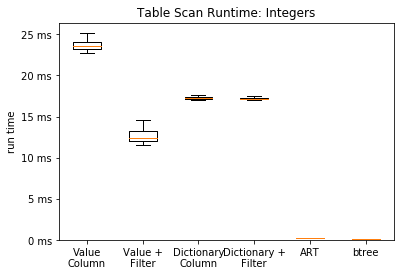

In [2]:
data = get_data()
btree_data        = select(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=1, art=0)
art_data          = select(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=1)
value_filter_data = select(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
dictionary_data   = select(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
dict_filter_data  = select(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
value_column_data = select(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
plot_data = [value_column_data, value_filter_data, dictionary_data, dict_filter_data, art_data, btree_data]
labels = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'Dictionary +\nFilter', 'ART', 'btree']
boxplot('Table Scan Runtime: Integers', plot_data, labels)

C:\Users\Arne\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


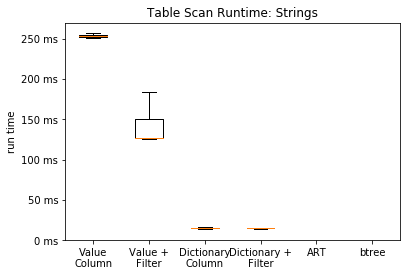

In [3]:
data = get_data()
btree_data        = select(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=1, art=0)
art_data          = select(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=1)
value_filter_data = select(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
dictionary_data   = select(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
dict_filter_data  = select(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
value_column_data = select(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
plot_data = [value_column_data, value_filter_data, dictionary_data, dict_filter_data, art_data, btree_data]
labels = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'Dictionary +\nFilter', 'ART', 'btree']
boxplot('Table Scan Runtime: Strings', plot_data, labels)

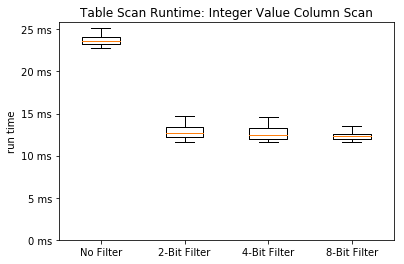

In [4]:
data = get_data()
series0 = select(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
series2 = select(data, data_type='int', pruning_rate=0.5, remainder_size=2, dictionary=0, btree=0, art=0)
series4 = select(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
series8 = select(data, data_type='int', pruning_rate=0.5, remainder_size=8, dictionary=0, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: Integer Value Column Scan', plot_data, labels)

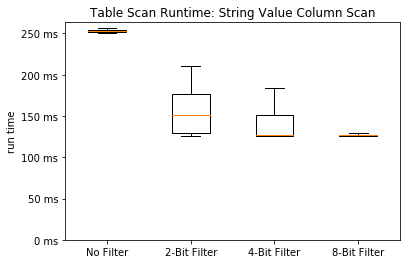

In [5]:
data = get_data()
series0 = select(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
series2 = select(data, data_type='string', pruning_rate=0.5, remainder_size=2, dictionary=0, btree=0, art=0)
series4 = select(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
series8 = select(data, data_type='string', pruning_rate=0.5, remainder_size=8, dictionary=0, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: String Value Column Scan', plot_data, labels)

C:\Users\Arne\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


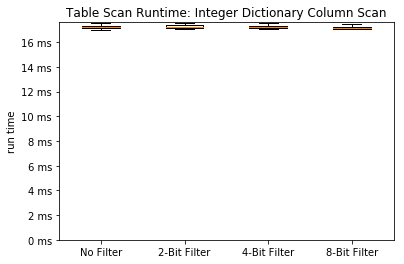

In [6]:
data = get_data()
series0 = select(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
series2 = select(data, data_type='int', pruning_rate=0.5, remainder_size=2, dictionary=1, btree=0, art=0)
series4 = select(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
series8 = select(data, data_type='int', pruning_rate=0.5, remainder_size=8, dictionary=1, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: Integer Dictionary Column Scan', plot_data, labels)

C:\Users\Arne\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


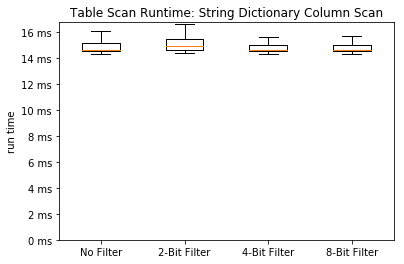

In [7]:
data = get_data()
series0 = select(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
series2 = select(data, data_type='string', pruning_rate=0.5, remainder_size=2, dictionary=1, btree=0, art=0)
series4 = select(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
series8 = select(data, data_type='string', pruning_rate=0.5, remainder_size=8, dictionary=1, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: String Dictionary Column Scan', plot_data, labels)